In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch running on " , DEVICE , ".\n")

# Define VAE architecture
class VAE(nn.Module):
    def __init__(self, num_channels, height, width, latent_size):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8*height*width, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        
        self.mean = nn.Sequential(
            nn.Linear(64, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size,latent_size)
        )
        
        self.logvar = nn.Sequential(
            nn.Linear(64, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size,latent_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_size,64),
            nn.ReLU(),
            nn.Linear(64,8*height*width),
            nn.ReLU(),
            nn.Unflatten(1,(8,height,width)),
            nn.Conv2d(8, 16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, num_channels, kernel_size=3,stride=1,padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decode
        x_recon = self.decoder(z)
        
        # Normalize along the 3rd and 4th dimensions (height and width)
        #min_values, _ = torch.min(x_recon, dim=2, keepdim=True)
        #min_values, _ = torch.min(min_values, dim=3, keepdim=True)

        #max_values, _ = torch.max(x_recon, dim=2, keepdim=True)
        #max_values, _ = torch.max(max_values, dim=3, keepdim=True)

        #x_recon = (x_recon - min_values) / (max_values - min_values)
        
        return x_recon, mu, logvar

# Training function
def train_vae(model, dataloader, num_epochs=10, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in trange(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = batch[0].to(device)  # Ignore labels from ImageFolder
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x,x,reduction="sum")
    
    # Reconstruction loss
    MSE = F.mse_loss(recon_x, x)
    
    #MAE = F.l1_loss(recon_x, x)
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + 1e-3 * KLD



Torch running on  cuda .



In [3]:
# Test function
def test_vae(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(batch)

            # Visualize original and reconstructed images
            visualize_images(batch, recon_batch)

# Visualization function
def visualize_images(original, reconstructed, num_images=5):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        
        reconstructed[i] = (reconstructed[i] - np.min(reconstructed[i])) / (np.max(reconstructed[i]) - np.min(reconstructed[i]))
        
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.show()

In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_folder, output_folder, transform=None):
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.transform = transform

        self.input_images = os.listdir(input_folder)
        self.output_images = os.listdir(output_folder)

    def __len__(self):
        return min(len(self.input_images), len(self.output_images))

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_folder, self.input_images[idx])
        output_path = os.path.join(self.output_folder, self.output_images[idx])

        input_image = Image.open(input_path)
        output_image = Image.open(output_path) #.convert('RGB')  # Convert to grayscale if necessary

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

def get_image_dataloader(input_folder, output_folder, batch_size=64, validation_split=0.6, random_seed=42):
    # Ensure input and output folders exist
    #assert os.path.exists(input_folder), f"Input folder '{input_folder}' does not exist."
    #assert os.path.exists(output_folder), f"Output folder '{output_folder}' does not exist."

    # Define data transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create datasets
    dataset = CustomDataset(input_folder,output_folder, transform=transform)
    dataset = torch.utils.data.Subset(dataset, range(2000))

    # Check if the number of samples in input and output datasets match
    #assert len(input_dataset) == len(output_dataset), "Input and output datasets must have the same number of samples."

    # Randomly split the datasets into training and validation sets
    total_samples = len(dataset)
    validation_size = int(validation_split * total_samples)
    train_size = total_samples - validation_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])


    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
if __name__ == "__main__":
    # Set your data path and other parameters
    input_image_path = "C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba_sketch"
    output_image_path= "C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba"
    
    batch_size = 10
    num_channels = 3  # Adjust based on your data
    height = 218
    width = 178
    latent_size = 20  # Adjust based on your desired latent space dimension

    # Initialize VAE
    vae_model = VAE(num_channels=num_channels, height = height, width = width, latent_size=latent_size)

    # Get data loader
    train_loader, val_loader = get_image_dataloader(input_image_path,output_image_path,batch_size)


    train=0
    if train:
        # Train VAE
        train_vae(vae_model, train_loader, num_epochs=100)
    
    
    # Instantiate the Convolutional VAE model and optimizer
    #conv_vae = ConvVAE(in_channels=1, out_channels=3,latent_size=latent_size)

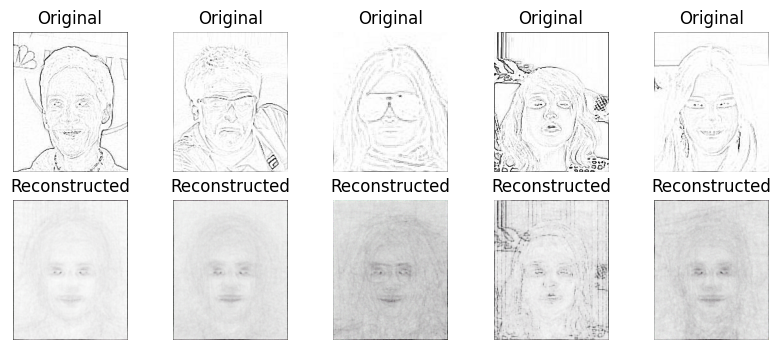

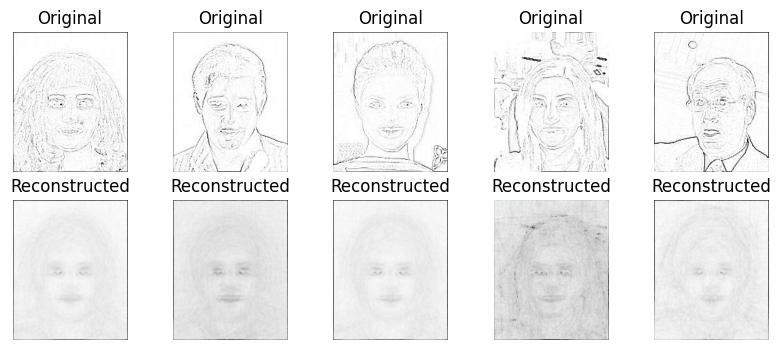

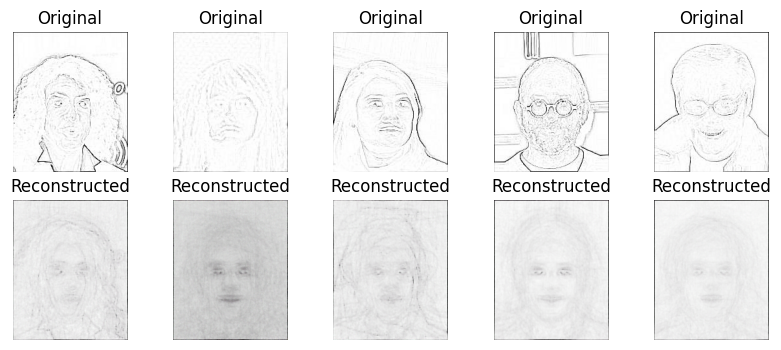

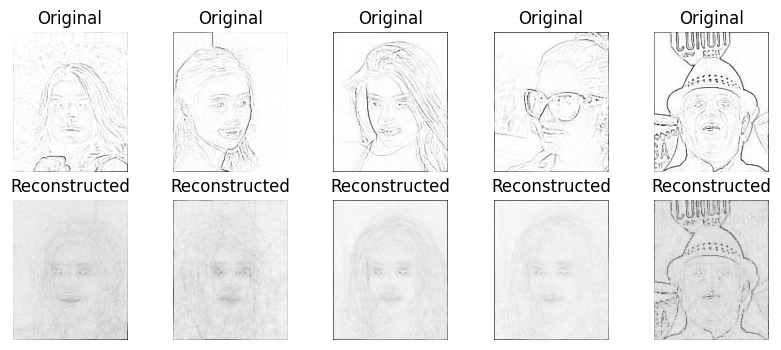

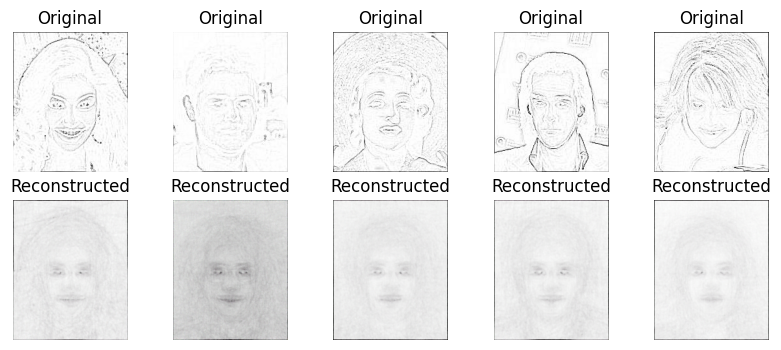

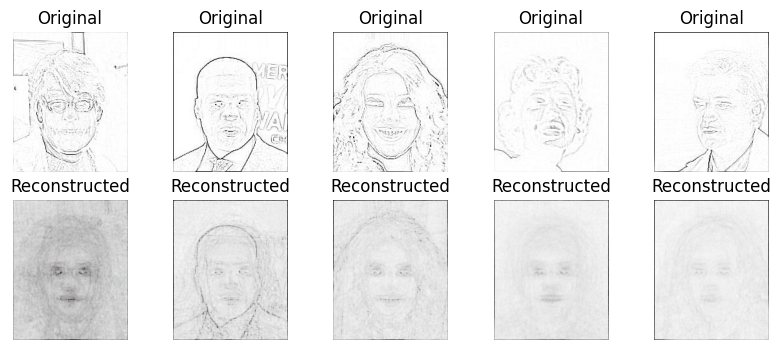

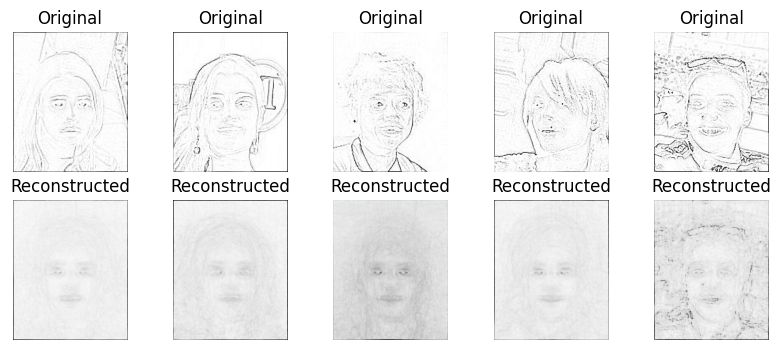

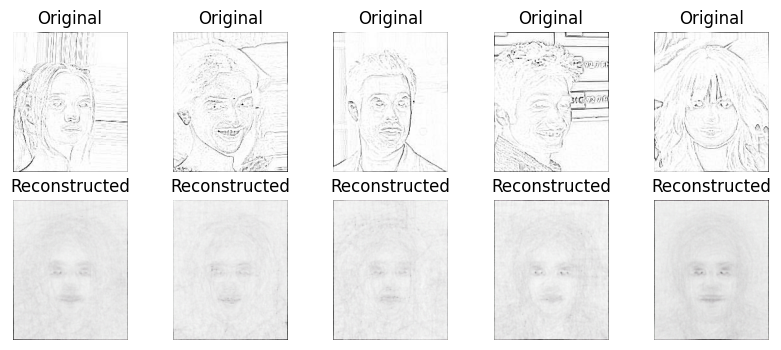

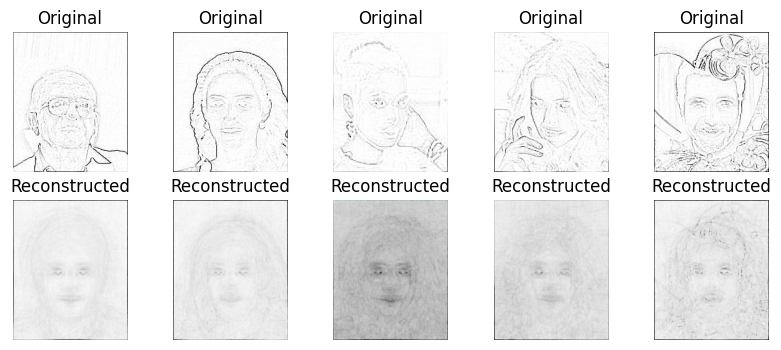

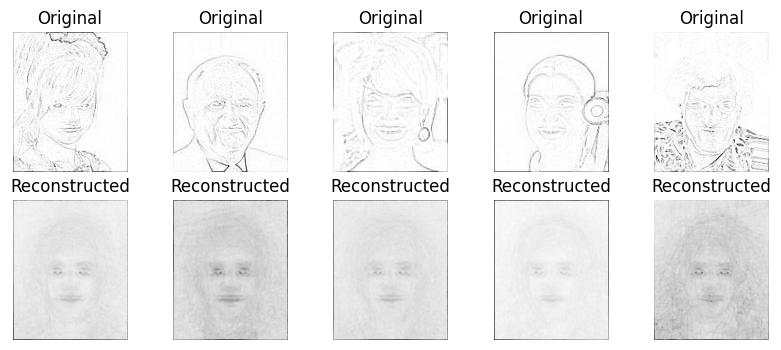

KeyboardInterrupt: 

In [9]:
test_vae(vae_model,train_loader)

In [ ]:
# save the model weights
save_params= 1
if save_params:
    torch.save(vae_model.state_dict(), "g2c_100epochs_MSE.pth")
    torch.save(vae_model, "model_g2c_100epochs_MSE.pth")

In [ ]:
vae_model.load_state_dict(torch.load("g2c_100epochs_MSE.pth"))
vae_model.eval()  # Set model to evaluation mode